# Final 50 Tickers

In [ ]:
lstSVM = ['TRGP', 'AMC', 'EXAS', 'OXY', 'LYV', 'JLL', 'FTI', 'OKE', 'SON', 'RRC', 'DVN', 'COTY', 'AR', 'EQT', 'NOV', 'IPG', 'WMB', 'PRGO', 'HES', 'T', 'MDB', 'SLB', 'MCK', 'HAL', 'CF', 'NWL', 'KR', 'BKR', 'KMI', 'AA', 'NTNX', 'OLN', 'AM', 'APLS', 'W', 'PNFP', 'LEG', 'VLO', 'WAL', 'LPX', 'AAL', 'MRO', 'NCLH', 'OMC', 'EWBC', 'FCX', 'TDC', 'UAL', 'CTRA', 'EQH']
lstClustering = ['LNT', 'AMC', 'AMT', 'AME', 'AMGN', 'NLY', 'AMAT', 'ARW', 'AJG', 'WRB', 'CRL', 'DAL', 'DFS', 'DTE', 'EMN', 'FERG', 'FR', 'FBIN', 'GIS', 'HD', 'H', 'KEY', 'LSTR', 'LBRDK', 'LSXMA', 'LMT', 'MCK', 'MSFT', 'MCO', 'NEM', 'NNN', 'NUE', 'ORLY', 'PH', 'PEP', 'PRU', 'PHM', 'PVH', 'RRC', 'SLB', 'NOW', 'TMO', 'UDR', 'RARE', 'UAA', 'UNH', 'UHS', 'VIRT', 'V', 'ZG']
lstGPT = ['AAPL', 'AMZN', 'GOOG', 'GOOGL', 'HD', 'INTC', 'JNJ', 'JPM', 'MA', 'MSFT', 'PG', 'T', 'V', 'VZ', 'UNH']

'''
lstCommon = []
for ClusteringTicker in lstClustering:
  if ClusteringTicker in lstSVM:
    lstCommon.append(ClusteringTicker)
print(lstCommon)
'''
for gptTickers in lstGPT:
  if gptTickers in lstClustering:
    print(gptTickers)

## Part 1: Import Libraries

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import yfinance as yf
import time
import random
from tqdm import tqdm
from pandas_datareader import data
from scipy.stats import zscore
import matplotlib.pyplot as plt
import requests
from sklearn.impute import KNNImputer
from scipy.stats.mstats import gmean
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from datetime import datetime
import json
!pip install PyPortfolioOpt
from pypfopt import expected_returns
from google.colab import drive
drive.mount('/content/drive')
FolderPath = '/content/drive/My Drive/MIE479 Capstone Project/Final Code'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 969.4 kB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Part 2: Obtain Russell 1000 Tickers


In [ ]:
dfRussell1000 = pd.read_csv(f'{FolderPath}/Stock Selection/Data/russell_1000_tickers.csv')
Russell_1000 = list(dfRussell1000.Ticker)
lstMissingTickers = ['BRK.B', 'BKI', 'BF.A', 'BF.B', 'CWEN.A', 'HEI.A', 'LEN.B', 'UHAL.B'] # tickers with no information on Alpha Vantage

Mounted at /drive


## Part 3: Obtain Income Statements, Balance Sheets, and Cash Flow Statements from Alpha Vantage (ONLY NEED TO RUN ONCE)

In [ ]:
# Alpha Vantage API key: PGKO2NCIWRTFC9B4
# Premium API Key: FHTV65YBKG7W48JG (30 API calls per minute)

# obtain the three financial statements for each ticker
def parse_statements(lstTickers):
  dictIS, dictBS, dictCF = {}, {}, {}
  lstStatements = ['INCOME_STATEMENT', 'BALANCE_SHEET', 'CASH_FLOW']
  strAPIKey = 'FHTV65YBKG7W48JG'
  intCount = 0
  intIteration = 0

  for strTicker in lstTickers:
    intIteration += 1
    for strStatementType in lstStatements:
      try:
        intCount += 1
        url = f'https://www.alphavantage.co/query?function={strStatementType}&symbol={strTicker}&apikey={strAPIKey}'
        dictStatements = requests.get(url).json()['quarterlyReports']
        if strStatementType == 'INCOME_STATEMENT':
          dictIS[strTicker] = dictStatements
        elif strStatementType == 'BALANCE_SHEET':
          dictBS[strTicker] = dictStatements
        else:
          dictCF[strTicker] = dictStatements
        if intCount >= 30:
          print(f'Iteration: {intIteration}. Sleep for 1 minute')
          time.sleep(61)
          intCount = 0
        else:
          continue

      except:
        if strStatementType == 'INCOME_STATEMENT':
          dictIS[strTicker] = None
        elif strStatementType == 'BALANCE_SHEET':
          dictBS[strTicker] = None
        else:
          dictCF[strTicker] = None
        if intCount >= 30:
          print(f'Iteration: {intIteration}. Sleep for 1 minute')
          time.sleep(61)
          intCount = 0

  return dictIS, dictBS, dictCF



In [ ]:
dictIS, dictBS, dictCF = parse_statements(Russell_1000)

'''
# store results
with open(f'{FolderPath}/Stock Selection/Data/SVM/dictIS.json', 'w') as f:
    json.dump(dictIS, f)

with open(f'{FolderPath}/Stock Selection/Data/SVM/dictBS.json', 'w') as f:
    json.dump(dictBS, f)

with open(f'{FolderPath}/Stock Selection/Data/SVM/dictCF.json', 'w') as f:
    json.dump(dictCF, f)

print(dictIS.keys())
print(dictBS.keys())
print(dictCF.keys())
'''

In [ ]:
# filter out the tickers with no information regarding financial data
lstMissingTickers = []
for key in dictIS.keys():
  if dictIS[key] is None:
    lstMissingTickers.append(key)

lstMissingTickers

['BRK.B', 'BKI', 'BF.A', 'BF.B', 'CWEN.A', 'HEI.A', 'LEN.B', 'UHAL.B']

## Part 4: Filter the Dates in the IS, BS, and CF

In [ ]:
# load data
with open(f'{FolderPath}/Stock Selection/Data/SVM/dictIS.json', 'r') as f:
  dictIS = json.load(f)
with open(f'{FolderPath}/Stock Selection/Data/SVM/dictBS.json', 'r') as f:
  dictBS = json.load(f)
with open(f'{FolderPath}/Stock Selection/Data/SVM/dictCF.json', 'r') as f:
  dictCF = json.load(f)


In [ ]:
for key in dictIS.keys():
  try:
    if not (dictIS[key][0]['fiscalDateEnding'] == dictBS[key][0]['fiscalDateEnding'] == dictCF[key][0]['fiscalDateEnding']):
      print(key)
  except:
    print(f'None value for ticker {key}')

# Note: only KVUE has a different latest date for IS, BS, and CF.
print(len(dictIS['KVUE']))
# However, there are only 2-year of data, so we won't be using KVUE's data when fitting the SVM

None value for ticker BRK.B
None value for ticker BKI
None value for ticker BF.A
None value for ticker BF.B
None value for ticker CWEN.A
None value for ticker HEI.A
KVUE
None value for ticker LEN.B
None value for ticker UHAL.B
8


In [ ]:
# filter out the dates that are after 2021-09-30
strDateCutOff = '2021-10-01'
dtCutOff = datetime.strptime(strDateCutOff, '%Y-%m-%d')
dictIS_filtered, dictBS_filtered, dictCF_filtered = {}, {}, {}

# filter IS, BS, and CF
for strTicker, lstInfo in dictIS.items():
  index = 0
  if lstInfo is None:  # no financial information for the ticker
    continue
  for dictRecord in lstInfo:
    strRecordDate = dictRecord['fiscalDateEnding']
    dtRecordDate = datetime.strptime(strRecordDate, '%Y-%m-%d')
    if dtRecordDate < dtCutOff:
      break
    else:
      index += 1
  # require at least 3-year's of data (12 quarters)
  minRecordLength = min(len(lstInfo), len(dictBS[strTicker]), len(dictCF[strTicker]))
  if (minRecordLength - index) >= 12:
    # handle the case where some tickers have different lengths for different financial statements, but with the same latest date (except: KVUE)
    dictIS_filtered[strTicker] = lstInfo[index:(index+12)]
    dictBS_filtered[strTicker] = dictBS[strTicker][index:(index+12)]
    dictCF_filtered[strTicker] = dictCF[strTicker][index:(index+12)]
  else:
    continue


'''
# filter BS
for strTicker, lstInfo in dictBS.items():
  index = 0
  if lstInfo is None:  # no financial information for the ticker
    continue
  for dictRecord in lstInfo:
    strRecordDate = dictRecord['fiscalDateEnding']
    dtRecordDate = datetime.strptime(strRecordDate, '%Y-%m-%d')
    if dtRecordDate < dtCutOff:
      break
    else:
      index += 1
  if (len(lstInfo) - index) >= 8:  # require at least 2-year's of data
    dictBS_filtered[strTicker] = lstInfo[index:]
  else:
    continue

# filter CF
for strTicker, lstInfo in dictCF.items():
  index = 0
  if lstInfo is None:  # no financial information for the ticker
    continue
  for dictRecord in lstInfo:
    strRecordDate = dictRecord['fiscalDateEnding']
    dtRecordDate = datetime.strptime(strRecordDate, '%Y-%m-%d')
    if dtRecordDate < dtCutOff:
      break
    else:
      index += 1
  if (len(lstInfo) - index) >= 8:  # require at least 2-year's of data
    dictCF_filtered[strTicker] = lstInfo[index:]
  else:
    continue
'''


In [ ]:
'''
# store filtered results
with open(f'{FolderPath}/Stock Selection/Data/SVM/dictIS_filtered.json', 'w') as f:
    json.dump(dictIS_filtered, f)

with open(f'{FolderPath}/Stock Selection/Data/SVM/dictBS_filtered.json', 'w') as f:
    json.dump(dictBS_filtered, f)

with open(f'{FolderPath}/Stock Selection/Data/SVM/dictCF_filtered.json', 'w') as f:
    json.dump(dictCF_filtered, f)
'''

## Part 6: Calculate Financial Ratios

In [ ]:
# load data
with open(f'{FolderPath}/Stock Selection/Data/SVM/dictIS_filtered.json', 'r') as f:
  dictIS_filtered = json.load(f)
with open(f'{FolderPath}/Stock Selection/Data/SVM/dictBS_filtered.json', 'r') as f:
  dictBS_filtered = json.load(f)
with open(f'{FolderPath}/Stock Selection/Data/SVM/dictCF_filtered.json', 'r') as f:
  dictCF_filtered = json.load(f)


In [ ]:
# generate the financial ratios from financial statements
def generate_ratios(strTicker, IS, BS, CF):
  dictMeasures = {}

  # grab stock price
  strDate = IS['fiscalDateEnding']
  strStartDate = (datetime.strptime(strDate, '%Y-%m-%d') - timedelta(days=1)).strftime('%Y-%m-%d')
  strEndDate = (datetime.strptime(strDate, '%Y-%m-%d') + timedelta(days=6)).strftime('%Y-%m-%d')
  try:
    stockPrice = yf.download(strTicker, start=strStartDate, end=strEndDate)['Adj Close'][0]
  except:
    stockPrice = np.nan

  # income statement
  dictMeasures['netIncome'] = IS['netIncome']
  dictMeasures['totalRevenue'] = IS['totalRevenue']
  dictMeasures['COGS'] = IS['costofGoodsAndServicesSold']
  dictMeasures['EBIT'] = IS['ebit']
  dictMeasures['EBITDA'] = IS['ebitda']
  dictMeasures['interestExpense'] = IS['interestExpense']

  # balance sheet
  dictMeasures['sharesOutstanding'] = BS['commonStockSharesOutstanding']
  dictMeasures['totalAssets'] = BS['totalAssets']
  dictMeasures['totalLiabilities'] = BS['totalLiabilities']
  dictMeasures['totalEquity'] = BS['totalShareholderEquity']
  dictMeasures['totalDebt'] = BS['shortLongTermDebtTotal']
  dictMeasures['cash'] = BS['cashAndCashEquivalentsAtCarryingValue']

  # cash flow statement
  dictMeasures['preferredDividends'] = CF['dividendPayoutPreferredStock']
  dictMeasures['dividendPayout'] = CF['dividendPayout']

  # convert 'None' values to 0
  # a 'None' in preferredDividends field -> no preferred dividends
  for measure, value in dictMeasures.items():
    if value == 'None':
      dictMeasures[measure] = 0
    else:
      dictMeasures[measure] = float(value)

  # ratio calculations
  dictRatios = {}
  dictRatios['Price'] = stockPrice
  dictRatios['Date'] = strDate
  try:
    dictRatios['EPS'] = (dictMeasures['netIncome'] - dictMeasures['preferredDividends']) / dictMeasures['sharesOutstanding']
  except:
    dictRatios['EPS'] = np.nan
  try:
    dictRatios['BVPS'] = (dictMeasures['totalAssets'] - dictMeasures['totalLiabilities']) / dictMeasures['sharesOutstanding']
  except:
    dictRatios['BVPS'] = np.nan
  try:
    dictRatios['PE'] = stockPrice / (4 * dictRatios['EPS'])
  except:
    dictRatios['PE'] = np.nan
  try:
    dictRatios['ROE'] = 4 * dictMeasures['netIncome'] / dictMeasures['totalEquity']
  except:
    dictRatios['ROE'] = np.nan
  try:
    dictRatios['ROA'] = 4 * dictMeasures['netIncome'] / dictMeasures['totalAssets']
  except:
    dictRatios['ROA'] = np.nan
  try:
    dictRatios['PB'] = stockPrice / dictRatios['BVPS']
  except:
    dictRatios['PB'] = np.nan
  try:
    dictRatios['ICR'] = dictMeasures['EBIT'] / dictMeasures['interestExpense'] # interest coverage ratio
  except:
    dictRatios['ICR'] = np.nan
  try:
    dictRatios['DE'] = dictMeasures['totalDebt'] / dictMeasures['totalEquity']
  except:
    dictRatios['DE'] = np.nan
  try:
    dictRatios['NPM'] = dictMeasures['netIncome'] / dictMeasures['totalRevenue'] # net profit margin
  except:
    dictRatios['NPM'] = np.nan
  try:
    dictRatios['DY'] = 4 * dictMeasures['dividendPayout'] / (stockPrice * dictMeasures['sharesOutstanding']) # dividend yield
  except:
    dictRatios['DY'] = np.nan
  try:
    dictRatios['DPR'] = dictMeasures['dividendPayout'] / dictMeasures['netIncome'] # dividend payout ratio
  except:
    dictRatios['DPR'] = np.nan
  try:
    dictRatios['EV'] = stockPrice * dictMeasures['sharesOutstanding'] + dictMeasures['totalDebt'] - dictMeasures['cash']
  except:
    dictRatios['EV'] = np.nan
  try:
    dictRatios['EV_EBITDA'] = dictRatios['EV'] / (dictMeasures['EBITDA'] * 4)
  except:
    dictRatios['EV_EBITDA'] = np.nan

  # summarize information into dataframe
  dfRatios = pd.DataFrame([dictRatios], index=[strTicker])
  return dfRatios

'''
Sample companies to check
Source: https://stockanalysis.com/stocks/; https://finance.yahoo.com/
(1) NKE: all ratios are correct/close enough except for DE
(2) NVDA: ROE, ROA, ICR, and NPM are a bit off
(3) MCD: all ratios are correct/close enough
(4) JPM: DE, GPM are slightly off
(5) DTE: all ratios are correct/close enough
(6) VISA: all ratios are correct/close enough
'''


# generate financial ratio dataframe for all tickers for each quarter
def generate_dataframe(index, dictIS, dictBS, dictCF):
  dfRatioSummary = pd.DataFrame()
  for strTicker in dictIS.keys():
    dfTickerRatios = generate_ratios(strTicker, dictIS[strTicker][index], dictBS[strTicker][index], dictCF[strTicker][index])
    dfRatioSummary = pd.concat([dfRatioSummary, dfTickerRatios], axis=0)
  return dfRatioSummary




In [ ]:
# generate financial ratio dataframes
n = 12 # 12 quarters in total
for i in range(n):
  print(f'Calculating Financial Ratios for Q{n-i}')
  dfRatioSummary = generate_dataframe(i, dictIS_filtered, dictBS_filtered, dictCF_filtered)
  dfRatioSummary.to_csv(f'{FolderPath}/Stock Selection/Data/SVM/financial_ratios_Q{n-i}.csv') # store table result


In [ ]:
# delete tickers RBC, FYBR, CI, NATL, CHK, HTZ, LLYVA, LLYVK, and AAP due to data quality issues and irregular statement publishing times (mamual check)
n = 12
for i in range(n):
  dfRatioSummary = pd.read_csv(f'{FolderPath}/Stock Selection/Data/SVM/financial_ratios_Q{i+1}.csv').rename(columns={'Unnamed: 0': 'Ticker'}).set_index('Ticker')
  dfRatioSummary = dfRatioSummary.drop(['RBC', 'FYBR', 'CI', 'NATL', 'CHK', 'HTZ', 'LLYVA', 'LLYVK', 'AAP'], axis=0)
  dfRatioSummary.to_csv(f'{FolderPath}/Stock Selection/Data/SVM/financial_ratios_Q{i+1}.csv')

## Part 7: Perform SVM

In [ ]:
# obtain annualized cumulative return for ticker
def get_return(strTicker, strStartDate, strEndDate):
  lstAdjClose = yf.download(strTicker, start=strStartDate, end=strEndDate)['Adj Close']
  mu_return = expected_returns.mean_historical_return(lstAdjClose.to_frame(),frequency=252) # frequency X can be interpreted as the return over X days
  #print(lstAdjClose)
  return mu_return['Adj Close']

#### Match Tickers with GICS Sector

In [ ]:
dfQ1 = pd.read_csv(f'{FolderPath}/Stock Selection/Data/SVM/financial_ratios_Q1.csv').rename(columns={'Unnamed: 0': 'Ticker'}).set_index('Ticker')
dfQ1.shape

In [ ]:
dfQ1 = pd.read_csv(f'{FolderPath}/Stock Selection/Data/SVM/financial_ratios_Q1.csv').rename(columns={'Unnamed: 0': 'Ticker'}).set_index('Ticker')
dfRussell1000 = pd.read_csv(f'{FolderPath}/Stock Selection/Data/russell_1000_tickers.csv').set_index('Ticker')
lstTickers = list(dfQ1.index)
dictSectors = {}

for strTicker in lstTickers:
  dictSectors[strTicker] = [dfRussell1000.loc[strTicker]['GICS Sector']]

dfSector = pd.DataFrame.from_dict(dictSectors).transpose()
dfSector = dfSector.rename(columns={0: 'Sector'})
#dfSector.to_csv(f'{FolderPath}/Stock Selection/Data/SVM/ticker_sector.csv') # store results

#### Function for Generating the X Dataset

In [ ]:
def generate_X(lstQuarters, weight_type='equal', boolOneHot=True):
  impute_knn = KNNImputer(n_neighbors=3, weights="uniform")
  lstQuarters.sort()
  dictQuarters = {}

  # extract data and perform KNN imputation
  for q in lstQuarters:
    dfQuarter = pd.read_csv(f'{FolderPath}/Stock Selection/Data/SVM/financial_ratios_Q{q}.csv').rename(columns={'Unnamed: 0': 'Ticker'}).set_index('Ticker')
    dfRatios = dfQuarter.iloc[:, ~dfQuarter.columns.isin(['Price', 'Date', 'EV'])]
    dfRatios = dfRatios.replace([np.inf, -np.inf], np.nan)
    npQuarter = impute_knn.fit_transform(dfRatios)
    dictQuarters[q] = npQuarter

  # weight the observations
  if weight_type == 'equal':
    n = len(lstQuarters)
    npTrain = dictQuarters[lstQuarters[0]]
    for i in range(1, len(lstQuarters)):
      npTrain = npTrain + dictQuarters[lstQuarters[i]]
    npTrain = 1/n * npTrain
  elif weight_type == 'moving':
    n = sum([(i+1) for i in range(len(lstQuarters))])
    npTrain = 1/n * dictQuarters[lstQuarters[0]]
    for i in range(1, len(lstQuarters)):
      npTrain = npTrain + (i+1)/n * dictQuarters[lstQuarters[i]]

  # perform rank normalization
  dfTrain = pd.DataFrame(npTrain)
  dfTrain_norm = dfTrain.rank() / (len(dfTrain) + 1)
  npTrain_norm = dfTrain_norm.to_numpy()

  # one-hot encoding based on sector
  if boolOneHot is True:
    dfTickers =  pd.read_csv(f'{FolderPath}/Stock Selection/Data/SVM/financial_ratios_Q1.csv')[['Ticker']].set_index('Ticker')
    dfSector = pd.read_csv(f'{FolderPath}/Stock Selection/Data/SVM/ticker_sector.csv').rename(columns={'Unnamed: 0': 'Ticker'}).set_index('Ticker')
    dfOneHot = pd.get_dummies(dfSector, prefix=['Sector'])
    dfOneHot = pd.merge(dfTickers, dfOneHot, left_index=True, right_index=True)[['Sector_Communication Services', 'Sector_Consumer Discretionary',
                                                                            'Sector_Consumer Staples', 'Sector_Energy',
                                                                            'Sector_Financials', 'Sector_Health Care',
                                                                            'Sector_Industrials', 'Sector_Information Technology',
                                                                            'Sector_Materials', 'Sector_Real Estate', 'Sector_Utilities']]

    npOneHot = dfOneHot.to_numpy()
    # conbine npTrain_norm and npOneHot
    npTrain_final = np.concatenate((npTrain_norm, npOneHot), axis=1)
    return npTrain_final
  else:
    return npTrain_norm



### Training

In [ ]:
# obtain X_train
lstTrainQuarters = [1,2,3,4]
npTrain_final = generate_X(lstTrainQuarters, 'moving')

# obtain y_vector
dfTickers =  pd.read_csv(f'{FolderPath}/Stock Selection/Data/SVM/financial_ratios_Q1.csv')[['Ticker']].set_index('Ticker')
dfYReturn = pd.read_csv(f'{FolderPath}/Stock Selection/Data/SVM/y_19Q3_20Q3.csv').rename(columns={'Ticker': 'Return', 'Unnamed: 0': 'Ticker'}).set_index('Ticker')
dfYReturn = pd.merge(dfTickers, dfYReturn, left_index=True, right_index=True)['Return']
Y_return = dfYReturn.to_numpy()
fltTop50 = sorted(Y_return, reverse=True)[50]
Y_train = (Y_return >= fltTop50)

'''
dfQ1 = pd.read_csv(f'{FolderPath}/Stock Selection/Data/SVM/financial_ratios_Q1.csv').rename(columns={'Unnamed: 0': 'Ticker'}).set_index('Ticker')
strStartDate, strEndDate = '2019-09-30', '2020-09-30' # 2019 Q3 to 2020 Q3
lstTickers = list(dfQ1.index)
dictReturns = {}

for strTicker in lstTickers:
  fltReturn = get_return(strTicker, strStartDate, strEndDate)
  dictReturns[strTicker] = [fltReturn]

dfReturns = pd.DataFrame.from_dict(dictReturns).transpose()
dfReturns = dfReturns.rename(columns={0: 'Ticker'})
dfReturns.to_csv(f'{FolderPath}/Stock Selection/Data/SVM/y_19Q3_20Q3.csv')
'''

"\ndfQ1 = pd.read_csv(f'{FolderPath}/Stock Selection/Data/SVM/financial_ratios_Q1.csv').rename(columns={'Unnamed: 0': 'Ticker'}).set_index('Ticker')\nstrStartDate, strEndDate = '2019-09-30', '2020-09-30' # 2019 Q3 to 2020 Q3\nlstTickers = list(dfQ1.index)\ndictReturns = {}\n\nfor strTicker in lstTickers:\n  fltReturn = get_return(strTicker, strStartDate, strEndDate)\n  dictReturns[strTicker] = [fltReturn]\n\ndfReturns = pd.DataFrame.from_dict(dictReturns).transpose()\ndfReturns = dfReturns.rename(columns={0: 'Ticker'})\ndfReturns.to_csv(f'{FolderPath}/Stock Selection/Data/SVM/y_19Q3_20Q3.csv')\n"

In [ ]:
# perform SVM
X_train = npTrain_final
#model = LinearSVC(dual=False, random_state=0, tol=1e-4, fit_intercept=True, class_weight='balanced')
model = SVC(gamma='auto', kernel='sigmoid', probability=True)
model.fit(X_train, Y_train)
#model_coef = model.coef_
#model_intercept = model.intercept_

print(model.score(X_train, Y_train, sample_weight=None))
#print(model.predict(X_train))
#print(f'Model Intercept: {model_intercept}; Model Coefficient:{model_coef}')

In [ ]:
l = dfQ1.index
result = np.matmul(X_train, model_coef.T)[:, 0]
r1 = result.argsort()[::-1][:50]
r2 = Y_return.argsort()[::-1]
for index in r1:
  #print(f'1-year return for {l[index]} is {Y_return[index]}')
  print(f'1-year return for {l[index]} is {Y_return[index]}')

In [ ]:
count = 0
for i in range(len(r1)):
  if np.where(r2==r1[i])[0][0]< 50:
    count+=1
  print(f'Predicted Position: {i}; Actual Position: {np.where(r2==r1[i])[0][0]}')
count

### Testing

In [ ]:
# obtain X_test
lstTestQuarters = [5,6,7,8]
npTest_final = generate_X(lstTestQuarters, 'moving')

# obtain y_vector
'''
dfQ1 = pd.read_csv(f'{FolderPath}/Stock Selection/Data/SVM/financial_ratios_Q1.csv').rename(columns={'Unnamed: 0': 'Ticker'}).set_index('Ticker')
strStartDate, strEndDate = '2020-09-30', '2021-09-30' # 2020 Q3 to 2021 Q3
lstTickers = list(dfQ1.index)
dictReturns = {}

for strTicker in lstTickers:
  fltReturn = get_return(strTicker, strStartDate, strEndDate)
  dictReturns[strTicker] = [fltReturn]

dfReturns = pd.DataFrame.from_dict(dictReturns).transpose()
dfReturns = dfReturns.rename(columns={0: 'Ticker'})
dfReturns.to_csv(f'{FolderPath}/Stock Selection/Data/SVM/y_20Q3_21Q3.csv')
'''

dfYReturn = pd.read_csv(f'{FolderPath}/Stock Selection/Data/SVM/y_20Q3_21Q3.csv').rename(columns={'Ticker': 'Return', 'Unnamed: 0': 'Ticker'}).set_index('Ticker')
dfYReturn = pd.merge(dfQ1, dfYReturn, left_index=True, right_index=True)['Return']
Y_return = dfYReturn.to_numpy()
fltTop50 = sorted(Y_return, reverse=True)[50]
Y_test = (Y_return >= fltTop50)



In [ ]:
# perform SVM
X_test= npTest_final
print(model.score(X_test, Y_test))
print(np.sum(model.predict(X_test)))
print(model.predict_proba(X_test))

In [ ]:
l = dfQ1.index
result = np.matmul(X_test, model_coef.T)[:, 0]
r1 = result.argsort()[::-1][:50]
r2 = Y_return.argsort()[::-1]
for index in r1:#r2[:50]:
  #print(f'1-year return for {l[index]} is {Y_return[index]}')
  print(f'1-year return for {l[index]} is {Y_return[index]}')

In [ ]:
count = 0
for i in range(len(r1)):
  if np.where(r2==r1[i])[0][0] <= 50:
    count+=1
  print(f'Predicted Position: {i}; Actual Position: {np.where(r2==r1[i])[0][0]}')
count

## Part 8: Hyperparameter Tuning

In [ ]:
# make tables that summarizes the training/testing performance of different SVM kernel-regularization parameter combinations
def make_tables(dictTrain, dictTest):
  dfScore = pd.DataFrame(columns=['Train Score', 'Train +1 #', 'Test Score', 'Test +1 #'])
  dfAvgRet = pd.DataFrame(columns=['Train Avg Ret', 'Test Avg Ret'])

  for key in dictTrain.keys():
    dfScoreTemp = pd.DataFrame(data={'Train Score': dictTrain[key]['Train Score'], 'Train +1 #': dictTrain[key]['Train Num Positive'],
                                     'Test Score': dictTest[key]['Test Score'], 'Test +1 #': dictTest[key]['Test Num Positive']}, index=[key])
    dfAvgRetTemp = pd.DataFrame(data={'Train Avg Ret': dictTrain[key]['Train Avg Return'],
                                      'Test Avg Ret': dictTest[key]['Test Avg Return']}, index=[key])

    dfScore = pd.concat([dfScore, dfScoreTemp], axis=0)
    dfAvgRet = pd.concat([dfAvgRet, dfAvgRetTemp], axis=0)

  return (dfScore, dfAvgRet)

In [ ]:
def select_from_prob(X_dataset, model, k):
  prob = model.predict_proba(X_dataset)[:, 1]  # index 0: False/-1; index 1: True/+1
  selected_positions = np.argsort(prob)[::-1][:k]  # select the k positions with the most probability of being True or +1
  return selected_positions

# compute average returns for the equally-weighted portfolio
def avg_returns(selected_positions, Y_return):
  selected_returns = Y_return[selected_positions]
  avg_return = np.average(selected_returns)
  return avg_return

In [ ]:

dfTickers =  pd.read_csv(f'{FolderPath}/Stock Selection/Data/SVM/financial_ratios_Q1.csv')[['Ticker']].set_index('Ticker')

# training set
lstTrainQuarters = [1, 2, 3, 4]
X_train = generate_X(lstTrainQuarters, 'equal')

dfYReturn_train = pd.read_csv(f'{FolderPath}/Stock Selection/Data/SVM/y_19Q3_20Q3.csv').rename(columns={'Ticker': 'Return', 'Unnamed: 0': 'Ticker'}).set_index('Ticker')
dfYReturn_train = pd.merge(dfTickers, dfYReturn_train, left_index=True, right_index=True)['Return']
Y_return_train = dfYReturn_train.to_numpy()
fltTop50 = sorted(Y_return_train, reverse=True)[49]
Y_train = (Y_return_train >= fltTop50)

# testing set
lstTestQuarters = [5, 6, 7, 8]
X_test = generate_X(lstTestQuarters, 'equal')

dfYReturn_test = pd.read_csv(f'{FolderPath}/Stock Selection/Data/SVM/y_20Q3_21Q3.csv').rename(columns={'Ticker': 'Return', 'Unnamed: 0': 'Ticker'}).set_index('Ticker')
dfYReturn_test = pd.merge(dfTickers, dfYReturn_test, left_index=True, right_index=True)['Return']
Y_return_test = dfYReturn_test.to_numpy()
fltTop50 = sorted(Y_return_test, reverse=True)[49] # top 50 stocks of highest performance
Y_test = (Y_return_test >= fltTop50) # True/+1 for top 50 stocks

In [ ]:
# basic / base-line model

# hyperparameters
lstKernel = ['linear', 'poly', 'rbf', 'sigmoid']  # kernel type
lstC = [0.1, 0.5, 1, 5, 10, 15]  # regularization parameter

dictTrain, dictTest = {}, {}

for kernel in lstKernel:
  for C in lstC:
    model = SVC(C=C, kernel=kernel, probability=True)
    #model = SVC(C=C, kernel=kernel, probability=True, class_weight='balanced')
    model.fit(X_train, Y_train)
    score_train = model.score(X_train, Y_train)
    num_positive_train = np.sum(model.predict(X_train))
    score_test = model.score(X_test, Y_test)
    num_positive_test = np.sum(model.predict(X_test))

    # train average return
    train_pos = select_from_prob(X_train, model, 50)
    train_avg_ret = avg_returns(train_pos, Y_return_train)

    # test average return
    test_pos = select_from_prob(X_test, model, 50)
    test_avg_ret = avg_returns(test_pos, Y_return_test)

    # record performance summary
    dictTrain[(kernel, C)] = {'Train Score': round(score_train, 4), 'Train Num Positive': num_positive_train, 'Train Avg Return': round(train_avg_ret, 4)}
    dictTest[(kernel, C)] = {'Test Score': round(score_test, 4), 'Test Num Positive': num_positive_test, 'Test Avg Return': round(test_avg_ret, 4)}




In [ ]:
dfScore, dfAvgRet = make_tables(dictTrain, dictTest)
print(dfScore)
print('------------------------------------------------')
print(dfAvgRet)

                Train Score Train +1 #  Test Score Test +1 #
(linear, 0.1)        0.9426          0      0.9426         0
(linear, 0.5)        0.9426          0      0.9426         0
(linear, 1)          0.9426          0      0.9426         0
(linear, 5)          0.9426          0      0.9426         0
(linear, 10)         0.9426          0      0.9426         0
(linear, 15)         0.9426          0      0.9426         0
(poly, 0.1)          0.9426          0      0.9426         0
(poly, 0.5)          0.9426          0      0.9426         0
(poly, 1)            0.9449          2      0.9426         0
(poly, 5)            0.9667         33      0.9219        26
(poly, 10)           0.9759         45      0.9116        37
(poly, 15)           0.9770         46      0.9070        39
(rbf, 0.1)           0.9426          0      0.9426         0
(rbf, 0.5)           0.9426          0      0.9426         0
(rbf, 1)             0.9518         14      0.9369         7
(rbf, 5)             0.9

In [ ]:
# A quick check to see if the highest probabilities are indeed classified as +1 or True - sanity check
# Saw no warning - all good
t = model.predict(X_test)
pos = np.where(t==True)[0]
prob = model.predict_proba(X_test)[:, 1]
prob_pos = prob.argsort()[::-1][:len(pos)]

for p in pos:
  if p not in prob_pos:
    print('WARNING')

## Part 9: Final Train and Predict

In [ ]:
# extract the predicted tickers
def extract_tickers(X_dataset, model, lstTickers, k):
  ticker_pos = select_from_prob(X_dataset, model, k) # get the position index for each of the predicted +1 stocks
  lstSelectedTickers = []
  # match the index position with the actual ticker name
  for index in ticker_pos:
    lstSelectedTickers.append(lstTickers[index])
  return lstSelectedTickers


In [ ]:
dfTickers =  pd.read_csv(f'{FolderPath}/Stock Selection/Data/SVM/financial_ratios_Q1.csv')[['Ticker']].set_index('Ticker')

# training set
lstTrainQuarters = [1, 2, 3, 4, 5, 6, 7, 8] # 2-year of data used as the final training
X_train = generate_X(lstTrainQuarters, 'equal')

dfYReturn_train = pd.read_csv(f'{FolderPath}/Stock Selection/Data/SVM/y_20Q3_21Q3.csv').rename(columns={'Ticker': 'Return', 'Unnamed: 0': 'Ticker'}).set_index('Ticker')
dfYReturn_train = pd.merge(dfTickers, dfYReturn_train, left_index=True, right_index=True)['Return']
Y_return_train = dfYReturn_train.to_numpy()
fltTop50 = sorted(Y_return_train, reverse=True)[49]
Y_train = (Y_return_train >= fltTop50)

model = SVC(C=10, kernel='rbf', probability=True)
model.fit(X_train, Y_train)
score_train = model.score(X_train, Y_train)
num_positive_train = np.sum(model.predict(X_train))
print(f'Training Score: {score_train}; Number of +1 Values: {num_positive_train}')

# predicting set
lstTestQuarters = [9 ,10, 11, 12]
X_predict = generate_X(lstTestQuarters, 'equal')
Y_predict = model.predict(X_predict)
print(f'Number of Predicted Y Stocks: {len(np.where(Y_predict==True)[0])}')
lst50Tickers = extract_tickers(X_predict, model, dfTickers.index, 50) # extract the 50 stocks with the highest probabilities of being +1
lst15Tickers = extract_tickers(X_predict, model, dfTickers.index, 15) # extract the 15 stocks with the highest probabilities of being +1

Training Score: 0.9667049368541906; Number of +1 Values: 23
Number of Predicted Y Stocks: 16


In [ ]:
dfYReturn_predict = pd.read_csv(f'{FolderPath}/Stock Selection/Data/SVM/y_21Q3_22Q3.csv').rename(columns={'Ticker': 'Return', 'Unnamed: 0': 'Ticker'}).set_index('Ticker')
dfYReturn_predict = pd.merge(dfTickers, dfYReturn_predict, left_index=True, right_index=True)['Return']
Y_return_predict = dfYReturn_predict.to_numpy()

predict_pos = select_from_prob(X_predict, model, 15) # get the position index for each of the predicted +1 stocks
predict_avg_ret = avg_returns(predict_pos, Y_return_predict) # generate average return
predict_avg_ret

In [ ]:
print(lst15Tickers) # selected tickers

['TRGP', 'AMC', 'EXAS', 'OXY', 'LYV', 'JLL', 'FTI', 'OKE', 'SON', 'RRC', 'DVN', 'COTY', 'AR', 'EQT', 'NOV']


In [ ]:
print(lst50Tickers)

['TRGP', 'AMC', 'EXAS', 'OXY', 'LYV', 'JLL', 'FTI', 'OKE', 'SON', 'RRC', 'DVN', 'COTY', 'AR', 'EQT', 'NOV', 'IPG', 'WMB', 'PRGO', 'HES', 'T', 'MDB', 'SLB', 'MCK', 'HAL', 'CF', 'NWL', 'KR', 'BKR', 'KMI', 'AA', 'NTNX', 'OLN', 'AM', 'APLS', 'W', 'PNFP', 'LEG', 'VLO', 'WAL', 'LPX', 'AAL', 'MRO', 'NCLH', 'OMC', 'EWBC', 'FCX', 'TDC', 'UAL', 'CTRA', 'EQH']


In [ ]:
count = 0
for ticker in lst15Tickers:# ['AAPL', 'AMZN', 'GOOG', 'GOOGL', 'HD', 'INTC', 'JNJ', 'JPM', 'MA', 'MSFT', 'PG', 'T', 'V', 'VZ', 'UNH']: #dfTickers.index:
  if dfYReturn_predict.loc[ticker]:
    count += 1
    print(f'Annual return for {ticker} is: {dfYReturn_predict.loc[ticker]}')

count

## Part 10: Plot Ticker Composition

In [ ]:
# obtain the GICS sector for each ticker
dfSector = pd.read_csv(f'{FolderPath}/Stock Selection/Data/SVM/ticker_sector.csv').rename(columns={'Unnamed: 0': 'Ticker'}).set_index('Ticker')

dictSector = {}
for strTicker in lst50Tickers:
  try:
    strSector = dfSector.loc[strTicker].Sector
    if strSector in dictSector:
      dictSector[strSector] += 1
    else:
      dictSector[strSector] = 1
  except:
    print(f'Unknown Ticker: {strTicker}')


In [ ]:
dictSector

{'Energy': 19,
 'Communication Services': 5,
 'Health Care': 4,
 'Real Estate': 1,
 'Materials': 6,
 'Consumer Staples': 2,
 'Information Technology': 3,
 'Consumer Discretionary': 4,
 'Financials': 4,
 'Industrials': 2}

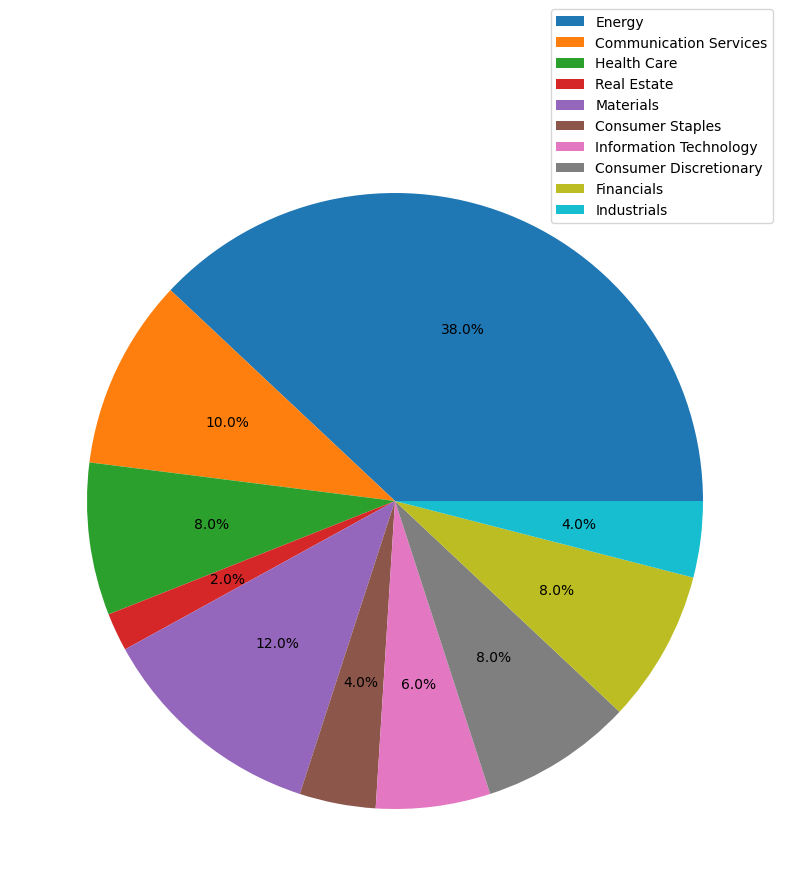

In [ ]:
# plot sector pie chart
labels = []
sizes = []

for x, y in dictSector.items():
    labels.append(x)
    sizes.append(y)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(sizes, autopct='%1.1f%%')
ax.legend(labels=labels, bbox_to_anchor=(1, 1), loc='right')
